In [208]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

df=pd.read_csv('dataset.csv')
df.head()

,month,tourists
0,2016-01,4510
1,2016-02,5030
2,2016-03,40
3,2016-04,318
4,2016-05,6102


In [209]:
df.tail()

,month,tourists
91,2023-08,103640
92,2023-09,102616
93,2023-10,117716
94,2023-11,105034
95,2023-12,124152


In [210]:
df['month']=pd.to_datetime(df['month'])
df.set_index('month',inplace=True)
df.head()

,tourists
month,
2016-01-01,4510
2016-02-01,5030
2016-03-01,40
2016-04-01,318
2016-05-01,6102


In [211]:
df.describe()

,tourists
count,96.000000
mean,19015.354167
std,34924.898789
min,0.000000
25%,3005.500000
50%,6084.500000
75%,9773.750000
max,124152.000000


<Axes: xlabel='month'>

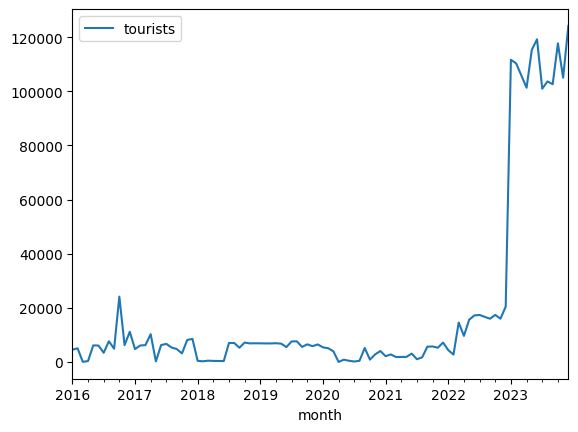

In [212]:
df.plot()

In [213]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(data):
    result = adfuller(data)
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(label + ' : ' + str(value))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary")

adfuller_test(df['tourists'])


ADF Test Statistic : -0.008382728004580252
p-value : 0.9578333256230139
#Lags Used : 0
Number of Observations Used : 95
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary


In [214]:
df['tourism difference'] = df['tourists'] - df['tourists'].shift(1)
df['tourists'].shift(1)

month
2016-01-01         NaN
2016-02-01      4510.0
2016-03-01      5030.0
2016-04-01        40.0
2016-05-01       318.0
                ...   
2023-08-01    100945.0
2023-09-01    103640.0
2023-10-01    102616.0
2023-11-01    117716.0
2023-12-01    105034.0
Name: tourists, Length: 96, dtype: float64

In [215]:
df['seasonal first difference']=df['tourists']-df['tourists'].shift(12)
df.tail(14)

,tourists,tourism difference,seasonal first difference
month,,,
2022-11-01,15973,-1408.0,10732.0
2022-12-01,20431,4458.0,13290.0
2023-01-01,111648,91217.0,107280.0
2023-02-01,110306,-1342.0,107603.0
2023-03-01,105829,-4477.0,91271.0
2023-04-01,101310,-4519.0,91697.0
2023-05-01,115310,14000.0,99732.0
2023-06-01,119212,3902.0,102033.0
2023-07-01,100945,-18267.0,83593.0


In [216]:
adfuller_test(df['seasonal first difference'].dropna())

ADF Test Statistic : -0.5871392416887747
p-value : 0.8738616311635683
#Lags Used : 0
Number of Observations Used : 83
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary


<Axes: xlabel='month'>

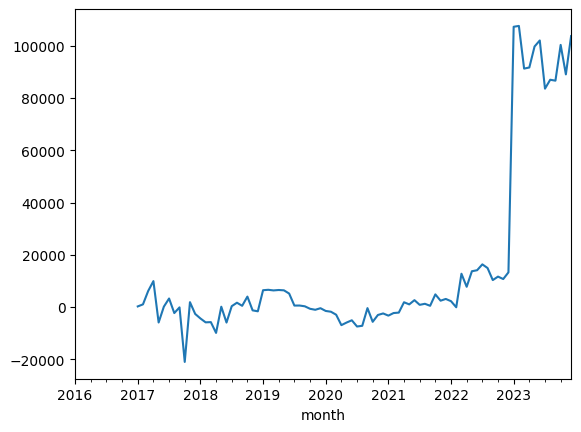

In [217]:
df['seasonal first difference'].plot()

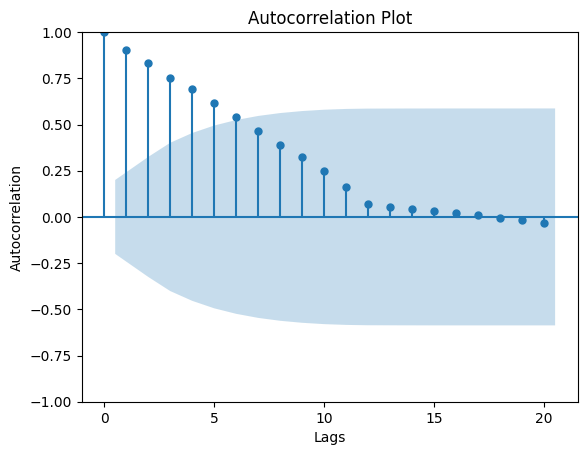

In [218]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plot_acf(df['tourists'])
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Plot')
plt.show()

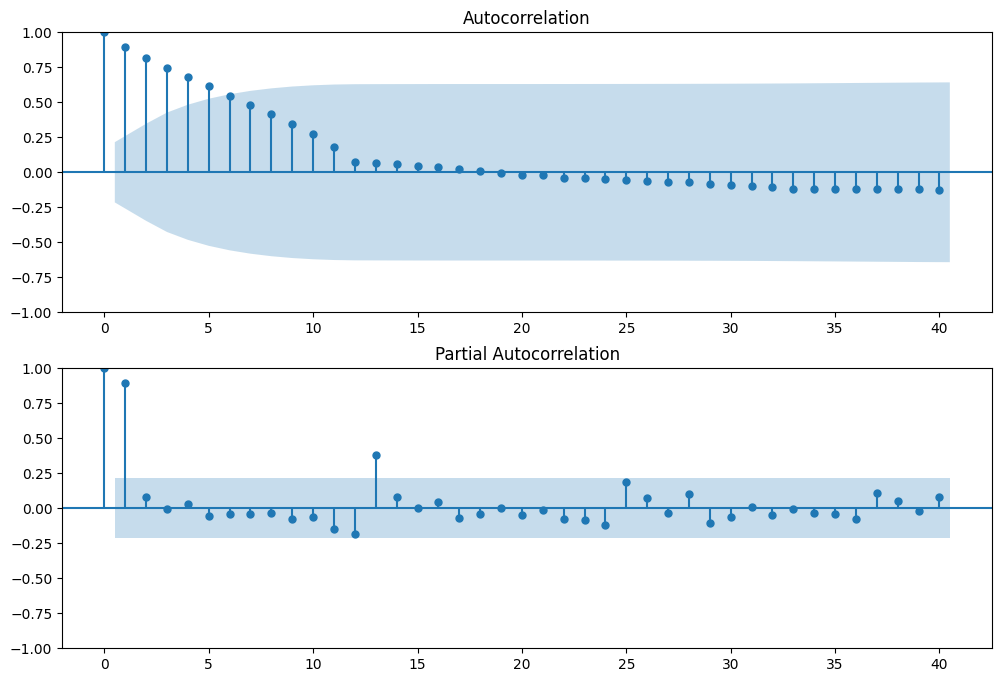

In [219]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['seasonal first difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['seasonal first difference'].iloc[13:],lags=40,ax=ax2)


In [220]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [221]:
df.tail()

,tourists,tourism difference,seasonal first difference
month,,,
2023-08-01,103640,2695.0,87005.0
2023-09-01,102616,-1024.0,86650.0
2023-10-01,117716,15100.0,100335.0
2023-11-01,105034,-12682.0,89061.0
2023-12-01,124152,19118.0,103721.0


In [222]:
df.index.freq = 'MS'
train, test = df.iloc[:96, 0], df.iloc[96:, 0]

In [223]:
model = ExponentialSmoothing(train, 
                             trend='add', 
                             damped=False, 
                             seasonal='add', 
                             seasonal_periods=12).fit()

In [224]:
holt_pred = model.fittedvalues
holt_pred = holt_pred.astype(int)
print(holt_pred.tail)

<bound method NDFrame.tail of month
2016-01-01      5749
2016-02-01      5023
2016-03-01      4981
2016-04-01       934
2016-05-01     -1615
               ...  
2023-08-01    103965
2023-09-01    101938
2023-10-01    107708
2023-11-01    113261
2023-12-01    107652
Freq: MS, Length: 96, dtype: int32>


In [225]:
data_forecast = {'Holt Prediction': holt_pred}
df_forecast = pd.DataFrame(data_forecast)

# Simpan DataFrame ke dalam file CSV
df_forecast.to_csv('holt_forecast.csv', index=False)

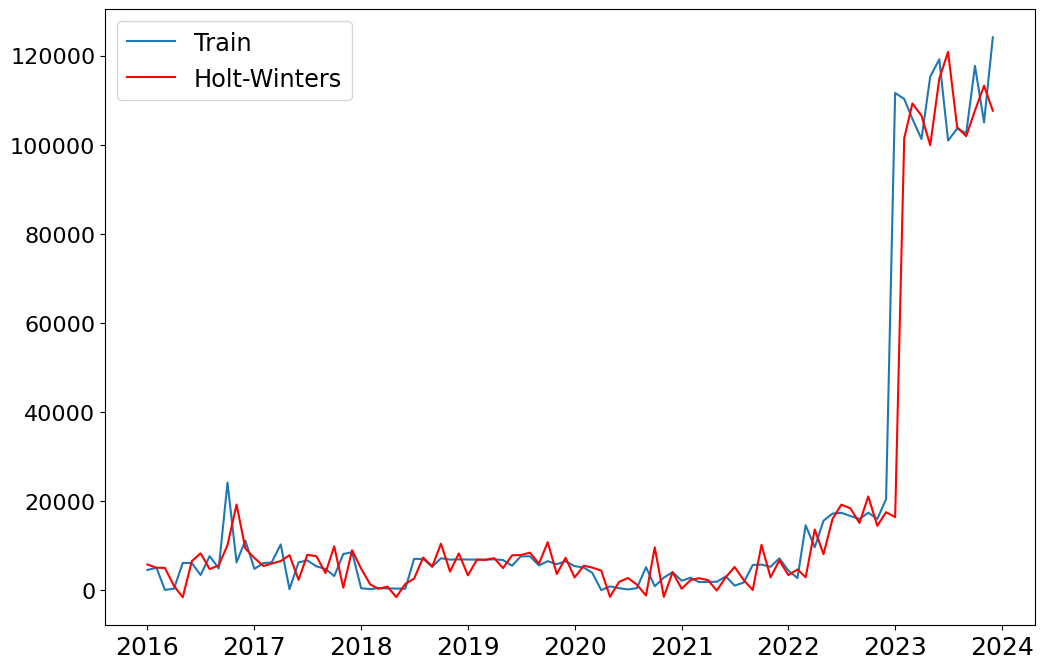

In [226]:
plt.figure(figsize=(12, 8))
plt.plot(train.index, train, label='Train')
plt.plot(holt_pred.index, holt_pred, label='Holt-Winters', color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

In [227]:
future_forecast = pd.date_range(start='2023-10-01', end='2024-12-01', freq='MS')
holt_pred = model.predict(start=future_forecast[0], end=future_forecast[-1])
holt_pred = holt_pred.astype(int)
print(holt_pred.tail(12))

2024-01-01    118607
2024-02-01    118984
2024-03-01    118947
2024-04-01    119302
2024-05-01    117315
2024-06-01    118584
2024-07-01    120729
2024-08-01    121539
2024-09-01    119803
2024-10-01    124974
2024-11-01    121630
2024-12-01    123337
Freq: MS, dtype: int32


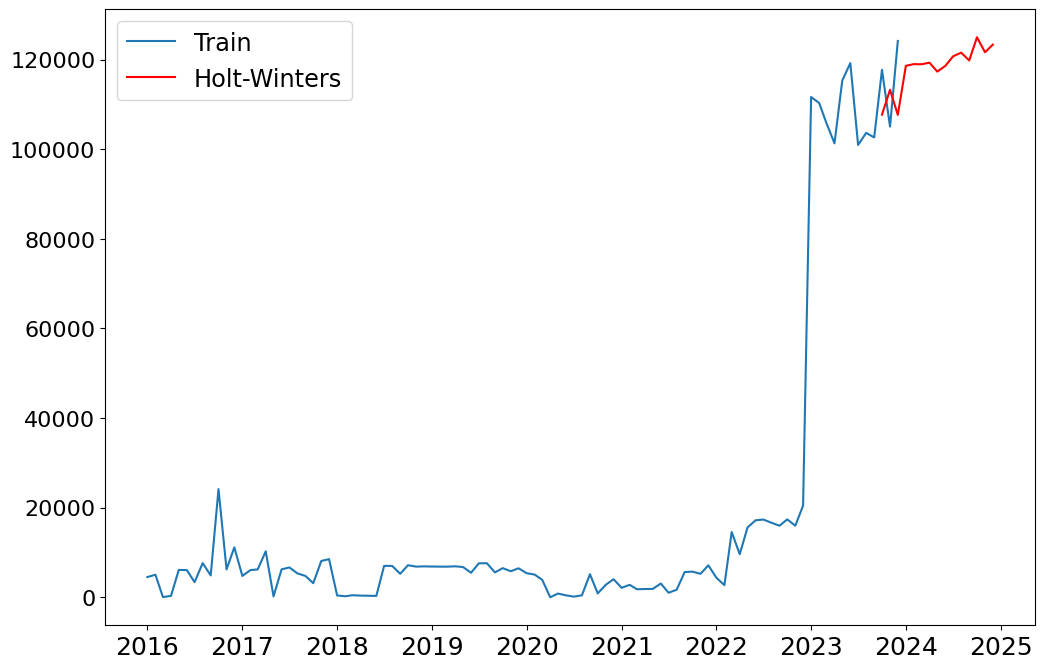

In [228]:
plt.figure(figsize=(12, 8))
plt.plot(train.index, train, label='Train')
plt.plot(holt_pred.index, holt_pred, label='Holt-Winters', color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

In [229]:
import statsmodels.api as sm

In [230]:
model=sm.tsa.statespace.SARIMAX(df['tourists'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           tourists   No. Observations:                   96
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -894.292
Date:                            Mon, 10 Jun 2024   AIC                           1798.583
Time:                                    13:46:28   BIC                           1810.678
Sample:                                01-01-2016   HQIC                          1803.442
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3845      1.781      0.216      0.829      -3.106       3.875
ma.L1         -0.4825      1.731     -0.279      0.780      -3.875       2.910
ar.S.L12      -0.3806      1.227     -0.310      0.756      -2.785       2.023
ma.S.L12      -0.2235      1.664     -0.134      0.893      -3.484       3.037
sigma2      1.468e+08   2.41e-07    6.1e+14      0.000    1.47e+08    1.47e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              8559.72
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):              13.88   Skew:                             6.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        51.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.3e+29. Standard errors may be unstable.
"""

<Axes: xlabel='month'>

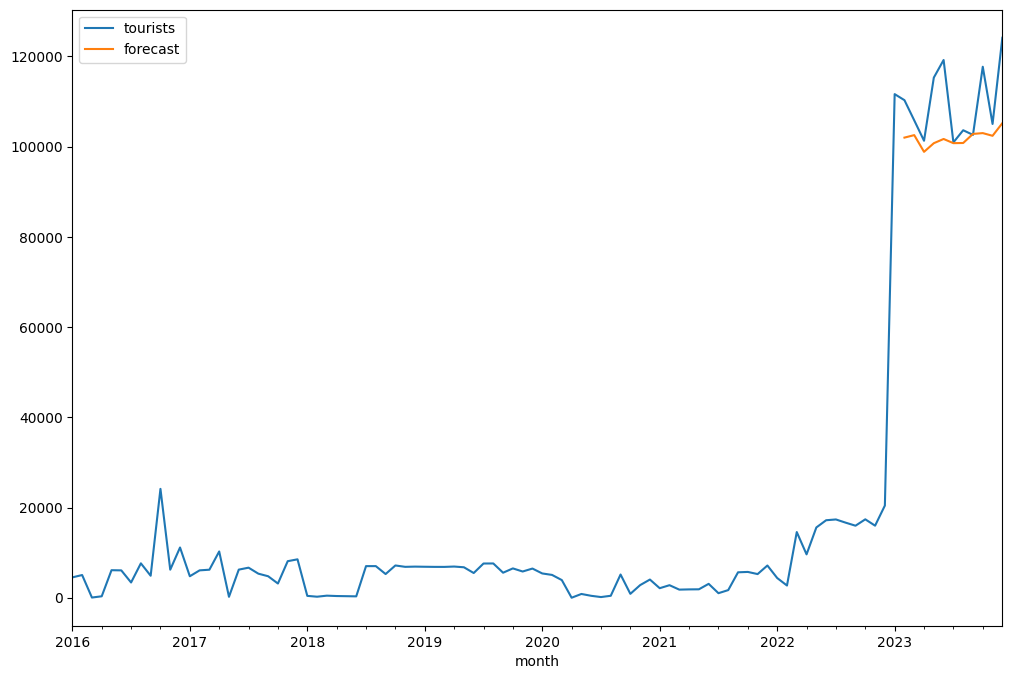

In [231]:
df['forecast']=results.predict(start=85,end=96,dynamic=True)
df[['tourists','forecast']].plot(figsize=(12,8))

In [232]:
df['forecast'] = df['forecast'].fillna(0).astype(int)
print(df.tail())

            tourists  tourism difference  seasonal first difference  forecast
month                                                                        
2023-08-01    103640              2695.0                    87005.0    100814
2023-09-01    102616             -1024.0                    86650.0    102823
2023-10-01    117716             15100.0                   100335.0    103005
2023-11-01    105034            -12682.0                    89061.0    102408
2023-12-01    124152             19118.0                   103721.0    105210


In [233]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,13)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)
future_datest_df.tail(12)

,tourists,tourism difference,seasonal first difference,forecast
2024-01-01,NaN,NaN,NaN,NaN
2024-02-01,NaN,NaN,NaN,NaN
2024-03-01,NaN,NaN,NaN,NaN
2024-04-01,NaN,NaN,NaN,NaN
2024-05-01,NaN,NaN,NaN,NaN
2024-06-01,NaN,NaN,NaN,NaN
2024-07-01,NaN,NaN,NaN,NaN
2024-08-01,NaN,NaN,NaN,NaN
2024-09-01,NaN,NaN,NaN,NaN
2024-10-01,NaN,NaN,NaN,NaN


In [234]:
future_df=pd.concat([df,future_datest_df])
future_df['forecast'] = results.predict(start = 94, end = 109, dynamic= True)
future_df['forecast'] = future_df['forecast'].fillna(0).astype(int)
print(future_df.tail(12))

           tourists  tourism difference  seasonal first difference  forecast
2024-01-01      NaN                 NaN                        NaN    152600
2024-02-01      NaN                 NaN                        NaN    151280
2024-03-01      NaN                 NaN                        NaN    154912
2024-04-01      NaN                 NaN                        NaN    150708
2024-05-01      NaN                 NaN                        NaN    159063
2024-06-01      NaN                 NaN                        NaN    161469
2024-07-01      NaN                 NaN                        NaN    154114
2024-08-01      NaN                 NaN                        NaN    154923
2024-09-01      NaN                 NaN                        NaN    154714
2024-10-01      NaN                 NaN                        NaN    161272
2024-11-01      NaN                 NaN                        NaN    159878
2024-12-01      NaN                 NaN                        NaN    163123

<Axes: >

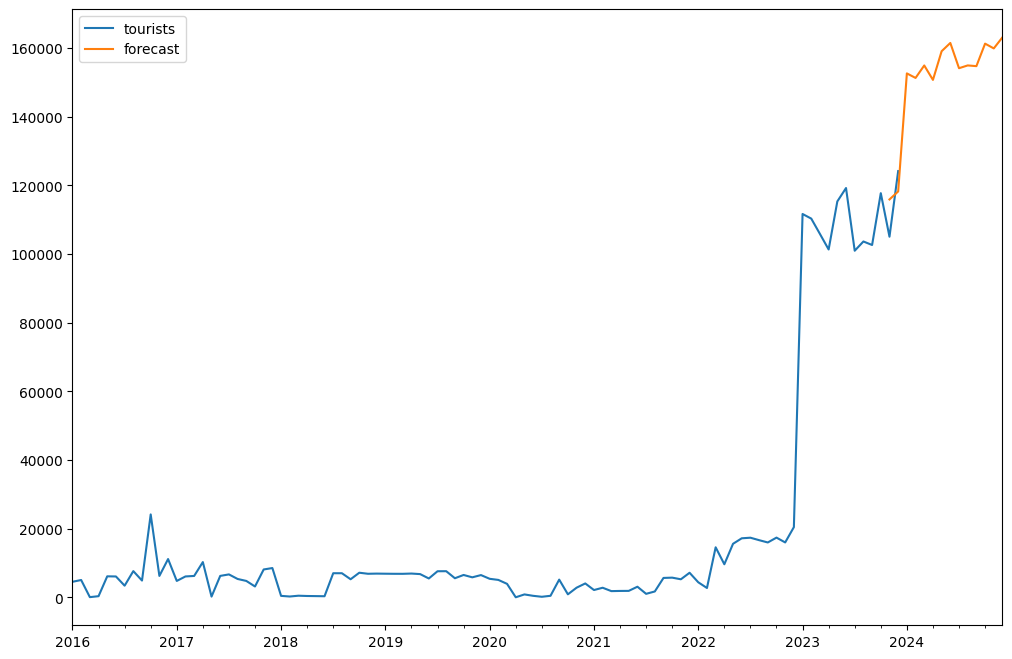

In [235]:
future_df['forecast'] = results.predict(start = 94, end = 109, dynamic= True)
future_df[['tourists', 'forecast']].plot(figsize=(12, 8)) 

<Axes: >

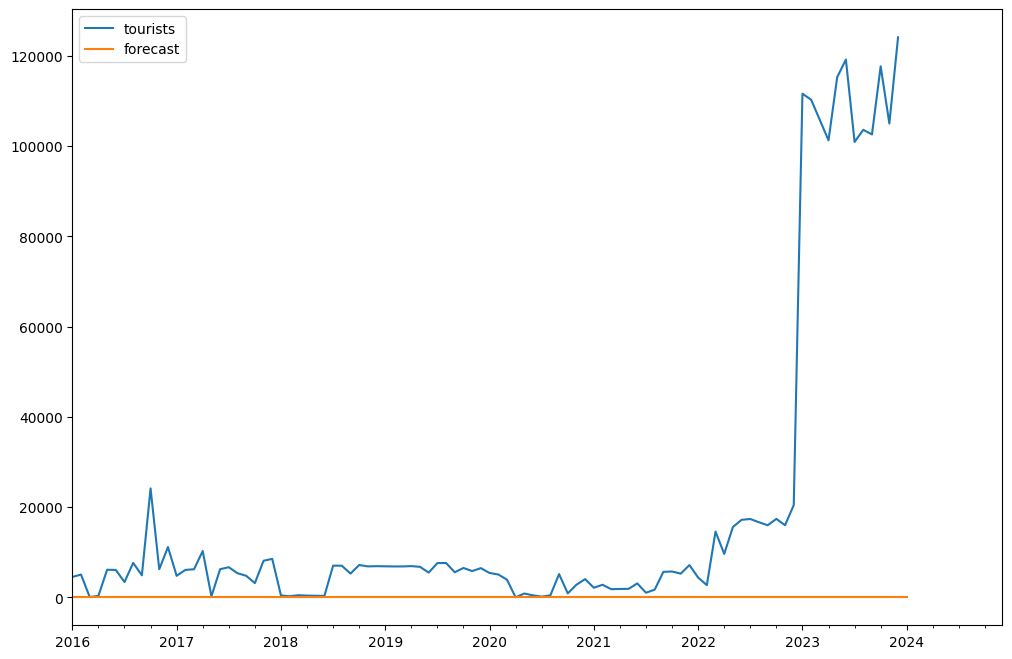

In [236]:
future_df['forecast'] = results.predict(start = 0, end = 96, dynamic= True)
future_df[['tourists', 'forecast']].plot(figsize=(12, 8)) 